In [33]:

import numpy as np
import pandas as pd
from scipy.signal import welch
import ace_tools_open as tools; 
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

def bandpass_filter(data, fs, low=1, high=30, order=5):
    nyq = fs / 2
    b, a = butter(order, [low / nyq, high / nyq], btype='band')
    return filtfilt(b, a, data, axis=0)

channel_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz']

df = pd.read_csv("data/d1.csv")
df.head()



,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,O2,...,F8,T7,T8,P7,P8,Fz,Cz,Pz,Class,ID
0,261,402,16,261,126,384,126,236,52,236,...,16,200,494,126,236,121,367,121,ADHD,v10p
1,121,191,-94,85,16,200,126,52,347,273,...,-57,126,347,52,52,15,121,-19,ADHD,v10p
2,-55,85,-204,15,-57,200,52,126,236,200,...,-94,126,420,52,126,-55,261,85,ADHD,v10p
3,191,85,52,50,89,236,163,89,89,89,...,-57,236,420,126,126,15,85,-55,ADHD,v10p
4,-55,-125,-204,-160,-204,16,-241,-241,89,16,...,-131,89,310,-57,52,-55,15,-336,ADHD,v10p


In [34]:
filtered_eeg = bandpass_filter(df[channel_names].values, fs=128)


filtered_df = df.copy()
filtered_df[channel_names] = filtered_eeg

# Display the filtered dataset
tools.display_dataframe_to_user(name="Filtered EEG Dataset", dataframe=filtered_df)


Filtered EEG Dataset


Loading ITables v2.4.2 from the internet... (need help?)


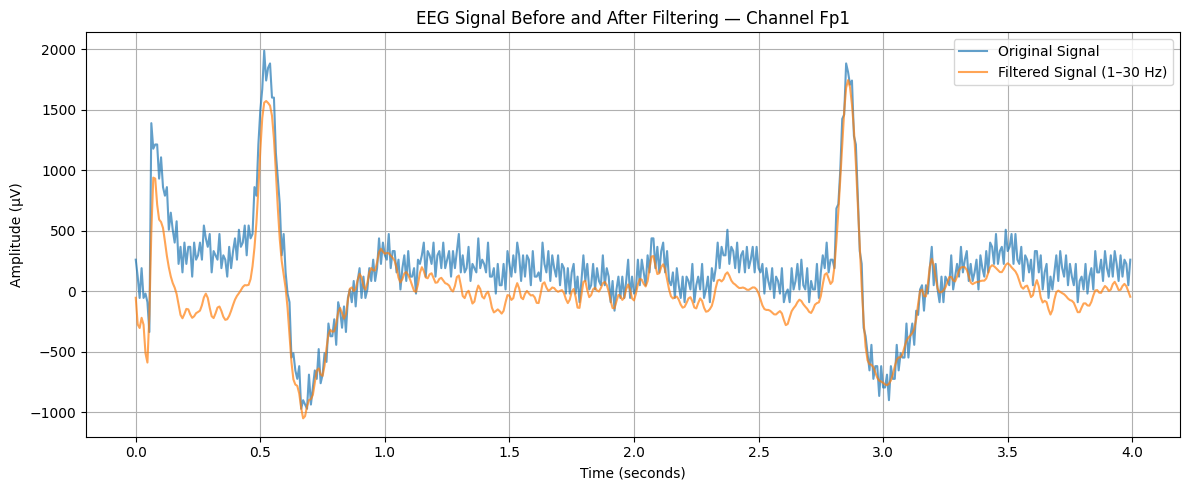

In [35]:
channel = 'Fp1'
samples_to_plot = 512  # About 4 seconds of data

# Extract the original and filtered signals
original_signal = df[channel].values[:samples_to_plot]
filtered_signal = filtered_df[channel].values[:samples_to_plot]
time = np.arange(samples_to_plot) / 128  # Time axis in seconds

# Plot
plt.figure(figsize=(12, 5))
plt.plot(time, original_signal, label='Original Signal', alpha=0.7)
plt.plot(time, filtered_signal, label='Filtered Signal (1–30 Hz)', alpha=0.7)
plt.title(f'EEG Signal Before and After Filtering — Channel {channel}')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:

# Parameters
fs = 128  # Sampling rate in Hz
epoch_length = 2 * fs  # 2 seconds = 256 samples
step_size = fs  # 50% overlap = 128 samples

# Container for features
features = []

# Process each subject individually
for subject_id in df['ID'].unique(): # sperate due ID
    subject_data = df[df['ID'] == subject_id].reset_index(drop=True) # copy data from corresponding data
    eeg_data = subject_data[channel_names].values # copy just the values out 
    label = subject_data['Class'].iloc[0] # label to ADHS and control


    # Sliding window
    for start in range(0, len(eeg_data) - epoch_length + 1, step_size):
        epoch = eeg_data[start:start + epoch_length, :]
        tbrs = []
        for ch in range(epoch.shape[1]):
            f, Pxx = welch(epoch[:, ch], fs=fs, nperseg=epoch_length)
            theta_power = np.trapezoid(Pxx[(f >= 4) & (f <= 8)], f[(f >= 4) & (f <= 8)])
            beta_power = np.trapezoid(Pxx[(f >= 13) & (f <= 30)], f[(f >= 13) & (f <= 30)])
            tbr = theta_power / beta_power if beta_power != 0 else 0
            tbrs.append(tbr)
        avg_tbr = np.mean(tbrs)
        features.append({
            'TBR': avg_tbr,
            'Class': label,
            'Subject_ID': subject_id
        })

# Convert to DataFrame
tbr_df = pd.DataFrame(features)

# Display result

tools.display_dataframe_to_user(name="Theta-Beta Ratio Features", dataframe=tbr_df)

Theta-Beta Ratio Features


Loading ITables v2.4.2 from the internet... (need help?)


In [38]:
tbr_df['Label'] = (tbr_df['Class'] == 'ADHD').astype(int)
tbr_df.head()

,TBR,Class,Subject_ID,Label
0,2.540336,ADHD,v10p,1
1,2.009620,ADHD,v10p,1
2,7.784762,ADHD,v10p,1
3,2.509106,ADHD,v10p,1
4,1.531071,ADHD,v10p,1


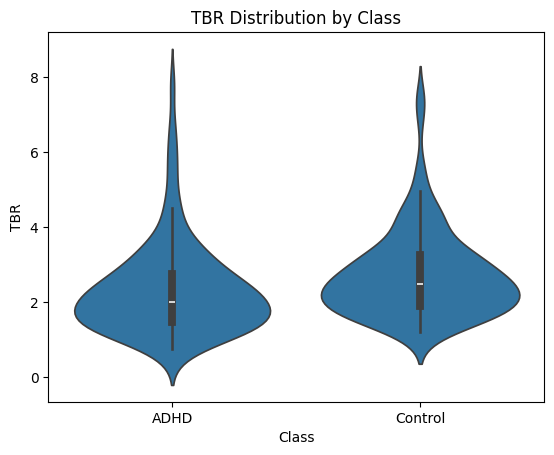

In [39]:
sns.violinplot(x='Class', y='TBR', data=tbr_df)
plt.title("TBR Distribution by Class")
plt.show()

In [41]:
from sklearn.model_selection import train_test_split

X = tbr_df[['TBR']]
y = tbr_df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)


In [42]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM (RBF kernel)": SVC(kernel='rbf', probability=True, random_state=42),
    "KNN (k=3)": KNeighborsClassifier(n_neighbors=3)
}

# Evaluate all models
reports = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    reports[name] = classification_report(y_test, y_pred, output_dict=True)
    print(f"=== {name} ===")
    print(classification_report(y_test, y_pred))
    print()

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.59      0.55      0.57        42
           1       0.47      0.52      0.49        33

    accuracy                           0.53        75
   macro avg       0.53      0.53      0.53        75
weighted avg       0.54      0.53      0.53        75


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.53      0.45      0.49        42
           1       0.41      0.48      0.44        33

    accuracy                           0.47        75
   macro avg       0.47      0.47      0.47        75
weighted avg       0.48      0.47      0.47        75


=== SVM (RBF kernel) ===
              precision    recall  f1-score   support

           0       0.59      0.76      0.67        42
           1       0.52      0.33      0.41        33

    accuracy                           0.57        75
   macro avg       0.56      0.55      0.54        

In [43]:
report_df = pd.concat({k: pd.DataFrame(v).T for k, v in reports.items()}, axis=1)
report_df.round(2)

Logistic Regression                         Random Forest         \
                       precision recall f1-score support     precision recall   
0                           0.59   0.55     0.57   42.00          0.53   0.45   
1                           0.47   0.52     0.49   33.00          0.41   0.48   
accuracy                    0.53   0.53     0.53    0.53          0.47   0.47   
macro avg                   0.53   0.53     0.53   75.00          0.47   0.47   
weighted avg                0.54   0.53     0.53   75.00          0.48   0.47   

                              SVM (RBF kernel)                          \
             f1-score support        precision recall f1-score support   
0                0.49   42.00             0.59   0.76     0.67   42.00   
1                0.44   33.00             0.52   0.33     0.41   33.00   
accuracy         0.47    0.47             0.57   0.57     0.57    0.57   
macro avg        0.47   75.00             0.56   0.55     0.54   75.00   
weighted avg     0.47   75.00             0.56   0.57     0.55   75.00   

             KNN (k=3)                          
             precision recall f1-score support  
0                 0.53   0.43     0.47   42.00  
1                 0.41   0.52     0.46   33.00  
accuracy          0.47   0.47     0.47    0.47  
macro avg         0.47   0.47     0.47   75.00  
weighted avg      0.48   0.47     0.47   75.00

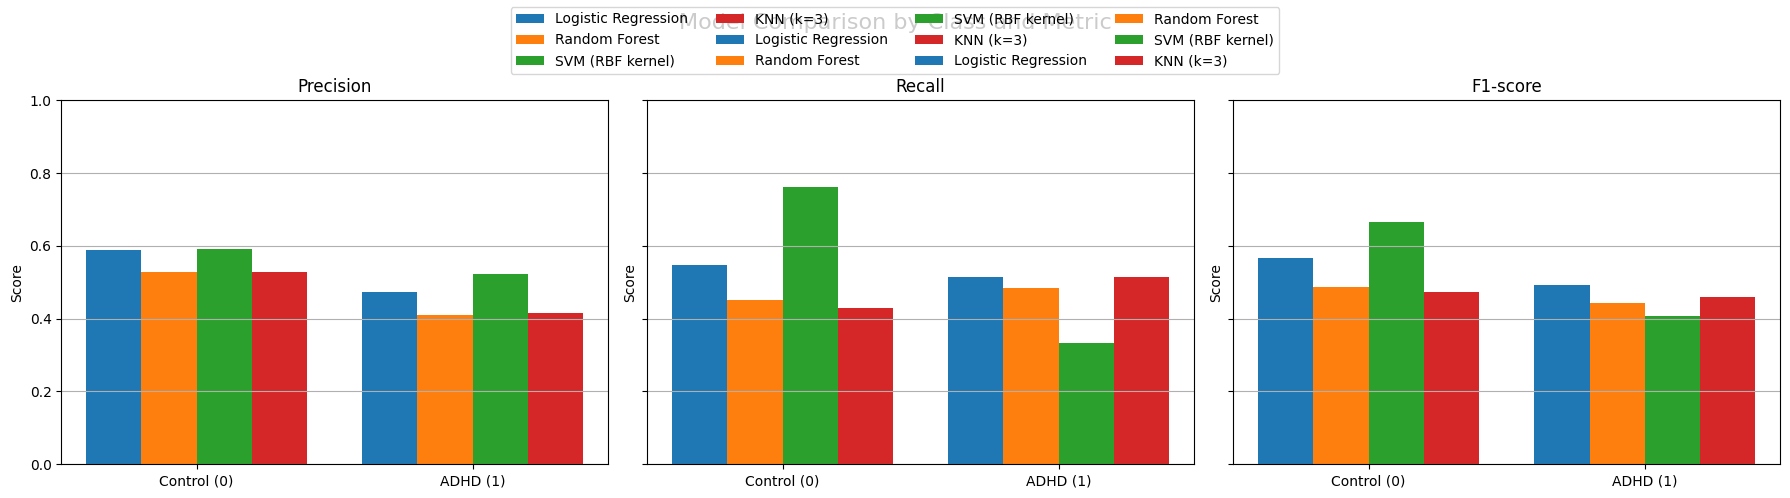

In [44]:
import matplotlib.pyplot as plt

# Extract key metrics for visualization
metrics_to_plot = ['precision', 'recall', 'f1-score']
class_labels = ['0', '1']  # 0 = Control, 1 = ADHD
metric_data = {}

# Collect metric data
for model_name, report in reports.items():
    for metric in metrics_to_plot:
        values = [report[label][metric] for label in class_labels]
        metric_data.setdefault(metric, {})[model_name] = values

# Plot settings
x = np.arange(len(class_labels))
width = 0.2
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Create grouped bar plots
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    for i, (model_name, values) in enumerate(metric_data[metric].items()):
        ax.bar(x + i * width, values, width, label=model_name, color=colors[i])
    ax.set_title(metric.capitalize())
    ax.set_xticks(x + width * (len(models) - 1) / 2)
    ax.set_xticklabels(['Control (0)', 'ADHD (1)'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Score')
    ax.grid(True, axis='y')

# Final plot adjustments
fig.suptitle('Model Comparison by Class and Metric', fontsize=16)
fig.legend(loc='upper center', ncol=4)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
